# Tree-based classifiers (DT, RF, ExtraRandomTrees, GradientBoostedTrees, XGBoost):

Classifying with supervised learning whether diabetic patients are readmitted, and if they are, if it's before or after 30 days.

Using the dataset from here: https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008

## TODO:
- additional cleanup and standardization
- randomsearchcv for randomforest
- randomsearchcv for gradientboostedtrees
- randomsearchcv for xgboost
- cleanup so that it's obvious what's going on with the cost function classification threshold tuning
- make it obvious where the model is being retrained on a subset of features for the purpose of creating the flask app model
- discuss the importance of model evaluation metric and why I settled on f1 macro or recall macro instead of something like accuracy

## Model evaluation and final model creation:

Once the best model was determined based on f1 macro score, the model was retrained on a subset of features for the purpose of creating the flask app model.

25 features seemed to be a reasonable amount to balance the effort it would take to input them into the dash UI while still retaining good model performance.



In [24]:
%matplotlib inline
import matplotlib.cm as cm
import random

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn import metrics

import pickle

In [2]:
with open("y_train_liv.pkl", 'rb') as picklefile: 
    y_train = pickle.load(picklefile)

with open("y_test_liv.pkl", 'rb') as picklefile: 
    y_test = pickle.load(picklefile)

with open("x_train_liv.pkl", 'rb') as picklefile: 
    x_train = pickle.load(picklefile)

with open("x_test_liv.pkl", 'rb') as picklefile: 
    x_test = pickle.load(picklefile)

## Binarizing classes:

In [3]:
y_test = y_test.str.replace('>30','NO')
y_train = y_train.str.replace('>30','NO')

## Decision tree with balanced class weights on single random train-test split:

In [4]:
decisiontree = DecisionTreeClassifier(class_weight='balanced')
decisiontree.fit(x_train, y_train)
y_pred = decisiontree.predict(x_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         <30       0.17      0.20      0.19      2839
          NO       0.90      0.88      0.89     22190

    accuracy                           0.80     25029
   macro avg       0.53      0.54      0.54     25029
weighted avg       0.81      0.80      0.81     25029



## Random forest with balanced class weights on single random train-test split:

In [5]:
randomforest = RandomForestClassifier(class_weight='balanced')
randomforest.fit(x_train, y_train)
y_pred = randomforest.predict(x_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         <30       0.54      0.00      0.01      2839
          NO       0.89      1.00      0.94     22190

    accuracy                           0.89     25029
   macro avg       0.71      0.50      0.47     25029
weighted avg       0.85      0.89      0.83     25029



## SMOTE:

In [6]:
sm = SMOTE(random_state=42)
x_train_smote, y_train_smote = sm.fit_sample(x_train, y_train)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [7]:
# sns.countplot(y_train);

In [8]:
# sns.countplot(y_train_smote);

In [9]:
randomforest = RandomForestClassifier()
randomforest.fit(x_train_smote, y_train_smote)
y_pred = randomforest.predict(x_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         <30       0.53      0.01      0.02      2839
          NO       0.89      1.00      0.94     22190

    accuracy                           0.89     25029
   macro avg       0.71      0.50      0.48     25029
weighted avg       0.85      0.89      0.84     25029



In [10]:
randomforest = RandomForestClassifier(n_estimators=200, min_samples_split=10)
randomforest.fit(x_train_smote, y_train_smote)
y_pred = randomforest.predict(x_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         <30       0.56      0.00      0.01      2839
          NO       0.89      1.00      0.94     22190

    accuracy                           0.89     25029
   macro avg       0.72      0.50      0.47     25029
weighted avg       0.85      0.89      0.83     25029



## Undersampling:

In [11]:
rus = RandomUnderSampler(random_state=0)
x_train_undersampled, y_train_undersampled = rus.fit_sample(x_train, y_train)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [12]:
# sns.countplot(y_train_undersampled);

In [13]:
randomforest = RandomForestClassifier(n_estimators=200)
randomforest.fit(x_train_undersampled, y_train_undersampled)
y_pred = randomforest.predict(x_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         <30       0.17      0.63      0.27      2839
          NO       0.93      0.61      0.74     22190

    accuracy                           0.61     25029
   macro avg       0.55      0.62      0.50     25029
weighted avg       0.84      0.61      0.69     25029



In [14]:
class_weights = {}
class_weights['NO'] = 1
class_weights['<30'] = 0.15
randomforest = RandomForestClassifier(n_estimators=200, class_weight = class_weights, min_samples_split=10)
randomforest.fit(x_train_undersampled, y_train_undersampled)
y_pred = randomforest.predict(x_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         <30       0.31      0.16      0.21      2839
          NO       0.90      0.96      0.93     22190

    accuracy                           0.87     25029
   macro avg       0.61      0.56      0.57     25029
weighted avg       0.83      0.87      0.85     25029



In [15]:
randomforest = RandomForestClassifier(n_estimators=200, min_samples_split=10)
randomforest.fit(x_train_undersampled, y_train_undersampled)
y_pred = randomforest.predict(x_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         <30       0.18      0.63      0.27      2839
          NO       0.93      0.62      0.74     22190

    accuracy                           0.62     25029
   macro avg       0.55      0.63      0.51     25029
weighted avg       0.84      0.62      0.69     25029



## Changing threshold:

In [16]:
model = randomforest
y_pred_proba = model.predict_proba(x_test)
y_pred = y_pred_proba[:,0] >= 0.25 # this is the value to play around with for changing threshold
label_dict = {True: '<30',
             False: 'NO',
            }
y_pred = [label_dict[elem] for elem in y_pred]
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         <30       0.11      0.99      0.21      2839
          NO       0.96      0.02      0.04     22190

    accuracy                           0.13     25029
   macro avg       0.54      0.51      0.12     25029
weighted avg       0.87      0.13      0.06     25029



In [17]:
randomforest = RandomForestClassifier(n_estimators=200, min_samples_split=20)
randomforest.fit(x_train_undersampled, y_train_undersampled)
y_pred = randomforest.predict(x_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         <30       0.18      0.64      0.28      2839
          NO       0.93      0.63      0.75     22190

    accuracy                           0.63     25029
   macro avg       0.55      0.63      0.51     25029
weighted avg       0.85      0.63      0.69     25029



In [18]:
randomforest = RandomForestClassifier(n_estimators=1000, min_samples_split=10)
randomforest.fit(x_train_undersampled, y_train_undersampled)
y_pred = randomforest.predict(x_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         <30       0.18      0.63      0.28      2839
          NO       0.93      0.63      0.75     22190

    accuracy                           0.63     25029
   macro avg       0.55      0.63      0.51     25029
weighted avg       0.84      0.63      0.70     25029



## Extra-random trees:

In [20]:
extraforest = ExtraTreesClassifier(n_estimators=200, min_samples_split=10)
extraforest.fit(x_train_undersampled, y_train_undersampled)
y_pred = extraforest.predict(x_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         <30       0.17      0.63      0.27      2839
          NO       0.93      0.60      0.73     22190

    accuracy                           0.61     25029
   macro avg       0.55      0.62      0.50     25029
weighted avg       0.84      0.61      0.68     25029



In [21]:
extraforest = ExtraTreesClassifier(n_estimators=2000)
extraforest.fit(x_train_undersampled, y_train_undersampled)
y_pred = extraforest.predict(x_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         <30       0.17      0.62      0.26      2839
          NO       0.93      0.60      0.73     22190

    accuracy                           0.60     25029
   macro avg       0.55      0.61      0.50     25029
weighted avg       0.84      0.60      0.68     25029



In [22]:
for n_estimator in range(100, 2000, 100):
    extraforest = ExtraTreesClassifier(n_estimators=n_estimator)
    extraforest.fit(x_train_undersampled, y_train_undersampled)
    y_pred = extraforest.predict(x_test)
    print("Number of estimators: %.3f"% n_estimator)
    print(metrics.classification_report(y_test, y_pred))

Number of estimators: 100.000
              precision    recall  f1-score   support

         <30       0.16      0.62      0.25      2839
          NO       0.92      0.58      0.71     22190

    accuracy                           0.58     25029
   macro avg       0.54      0.60      0.48     25029
weighted avg       0.84      0.58      0.66     25029

Number of estimators: 200.000
              precision    recall  f1-score   support

         <30       0.16      0.62      0.26      2839
          NO       0.92      0.59      0.72     22190

    accuracy                           0.59     25029
   macro avg       0.54      0.60      0.49     25029
weighted avg       0.84      0.59      0.67     25029

Number of estimators: 300.000
              precision    recall  f1-score   support

         <30       0.16      0.62      0.26      2839
          NO       0.92      0.60      0.73     22190

    accuracy                           0.60     25029
   macro avg       0.54      0.61     

## Gradient Boosted Trees:

In [27]:
# boosted no resampling
GBT = GradientBoostingClassifier(n_estimators=200)
GBT.fit(x_train, y_train)
y_pred = GBT.predict(x_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         <30       0.55      0.01      0.03      2839
          NO       0.89      1.00      0.94     22190

    accuracy                           0.89     25029
   macro avg       0.72      0.51      0.48     25029
weighted avg       0.85      0.89      0.84     25029



In [28]:
# boosted undersampled
GBT = GradientBoostingClassifier(n_estimators=200)
GBT.fit(x_train_undersampled, y_train_undersampled)
y_pred = GBT.predict(x_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         <30       0.19      0.60      0.28      2839
          NO       0.93      0.66      0.77     22190

    accuracy                           0.65     25029
   macro avg       0.56      0.63      0.53     25029
weighted avg       0.84      0.65      0.72     25029



In [32]:
# boosted SMOTE
GBT = GradientBoostingClassifier(n_estimators=200)
GBT.fit(x_train_smote, y_train_smote)
y_pred = GBT.predict(x_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         <30       0.41      0.02      0.03      2839
          NO       0.89      1.00      0.94     22190

    accuracy                           0.89     25029
   macro avg       0.65      0.51      0.49     25029
weighted avg       0.83      0.89      0.84     25029



## Best model:

In [33]:
randomforest = RandomForestClassifier(n_estimators=200, min_samples_split=10)
randomforest.fit(x_train_undersampled, y_train_undersampled)
y_pred = randomforest.predict(x_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         <30       0.18      0.63      0.27      2839
          NO       0.93      0.62      0.75     22190

    accuracy                           0.62     25029
   macro avg       0.55      0.63      0.51     25029
weighted avg       0.84      0.62      0.69     25029



In [34]:
pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])

Predicted,<30,NO
Actual,,
<30,1786,1053
NO,8377,13813


In [35]:
feature_importance = list(zip(x_train.columns, randomforest.feature_importances_))

In [36]:
sorted_by_second = sorted(feature_importance, key=lambda tup: tup[1], reverse=True)

In [37]:
sorted_by_second[0:25]

[('num_lab_procedures', 0.055238732144548025),
 ('number_inpatient', 0.05445454201190723),
 ('num_medications', 0.04937069141555372),
 ('time_in_hospital', 0.03763746373746868),
 ('number_diagnoses', 0.027229070722661584),
 ('num_procedures', 0.025873139879785168),
 ('number_emergency', 0.016626432541461424),
 ('discharge_disposition_id_Discharged to home', 0.016530660084302713),
 ('number_outpatient', 0.016092219457622927),
 ('discharge_disposition_id_Discharged/transferred to another rehab fac including rehab units of a hospital .',
  0.010344528124542476),
 ('diag_1_Diseases Of The Circulatory System', 0.00929353658317021),
 ('diag_2_Diseases Of The Circulatory System', 0.009070506181030443),
 ('diag_3_Diseases Of The Circulatory System', 0.008938297578515853),
 ('medical_specialty_?', 0.008881378320218885),
 ('payer_code_?', 0.008872904608647461),
 ('payer_code_MC', 0.008582796003195527),
 ('age_[60-70)', 0.008496860837276583),
 ('age_[70-80)', 0.008453197249265536),
 ('gender_Male

In [38]:
coef_to_plot = sorted_by_second[0:25]

In [39]:
df = pd.DataFrame(coef_to_plot, columns=['feature','coefficient'])

In [40]:
df.head()

,feature,coefficient
0,num_lab_procedures,0.055239
1,number_inpatient,0.054455
2,num_medications,0.049371
3,time_in_hospital,0.037637
4,number_diagnoses,0.027229


In [48]:
# plt.bar(df.feature, df.coefficient)
# plt.xticks(rotation='vertical');
# plt.yticks(rotation='vertical');

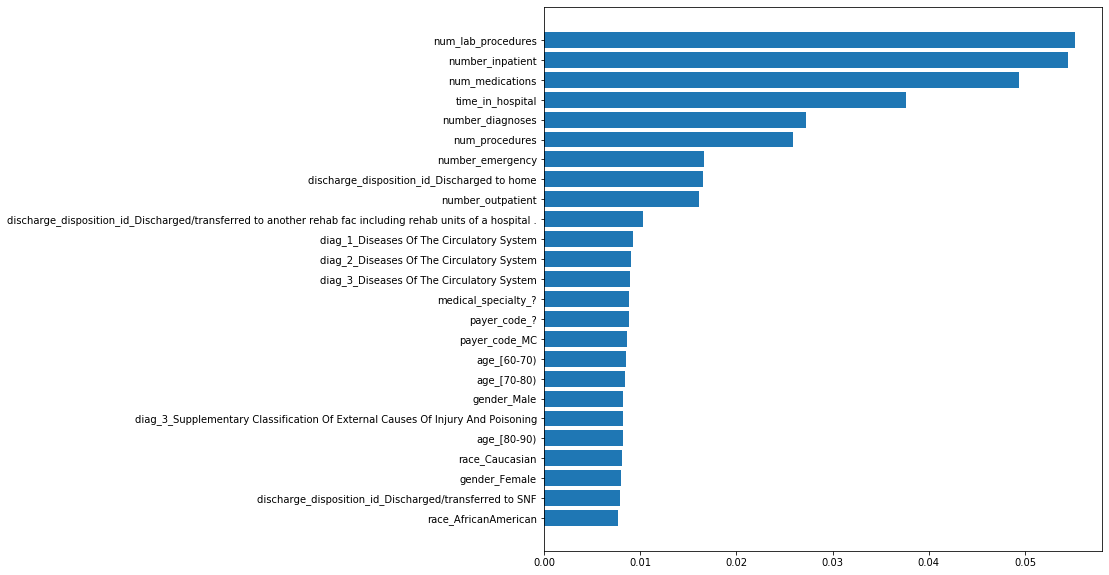

In [49]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.barh(df.feature, df.coefficient)
ax.invert_yaxis()

## Plotting the correlation between readmission and the top 25 predictive features:

In [50]:
list(df.feature.unique())

['num_lab_procedures',
 'number_inpatient',
 'num_medications',
 'time_in_hospital',
 'number_diagnoses',
 'num_procedures',
 'number_emergency',
 'discharge_disposition_id_Discharged to home',
 'number_outpatient',
 'discharge_disposition_id_Discharged/transferred to another rehab fac including rehab units of a hospital .',
 'diag_1_Diseases Of The Circulatory System',
 'diag_2_Diseases Of The Circulatory System',
 'diag_3_Diseases Of The Circulatory System',
 'medical_specialty_?',
 'payer_code_?',
 'payer_code_MC',
 'age_[60-70)',
 'age_[70-80)',
 'gender_Male',
 'diag_3_Supplementary Classification Of External Causes Of Injury And Poisoning',
 'age_[80-90)',
 'race_Caucasian',
 'gender_Female',
 'discharge_disposition_id_Discharged/transferred to SNF',
 'race_AfricanAmerican']

In [53]:
sub_x = x_train.copy()[list(df.feature.unique())]

In [55]:
sub_x['y'] = y_train

In [56]:
sub_x.head()

,num_lab_procedures,number_inpatient,num_medications,time_in_hospital,number_diagnoses,num_procedures,number_emergency,discharge_disposition_id_Discharged to home,number_outpatient,discharge_disposition_id_Discharged/transferred to another rehab fac including rehab units of a hospital .,...,age_[60-70),age_[70-80),gender_Male,diag_3_Supplementary Classification Of External Causes Of Injury And Poisoning,age_[80-90),race_Caucasian,gender_Female,discharge_disposition_id_Discharged/transferred to SNF,race_AfricanAmerican,y
43670,62,0,13,3,8,0,0,1,0,0,...,0,0,1,1,0,1,0,0,0,NO
23049,26,0,15,4,9,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,NO
14557,69,0,17,3,9,2,0,1,0,0,...,1,0,0,0,0,1,1,0,0,NO
54888,39,1,34,4,9,2,0,0,0,0,...,1,0,0,0,0,0,1,0,1,<30
86170,40,2,11,2,9,0,1,0,0,0,...,0,0,0,1,1,1,1,1,0,<30


In [57]:
sub_x.y = sub_x.y.replace('NO',0)
sub_x.y = sub_x.y.replace('<30',1)

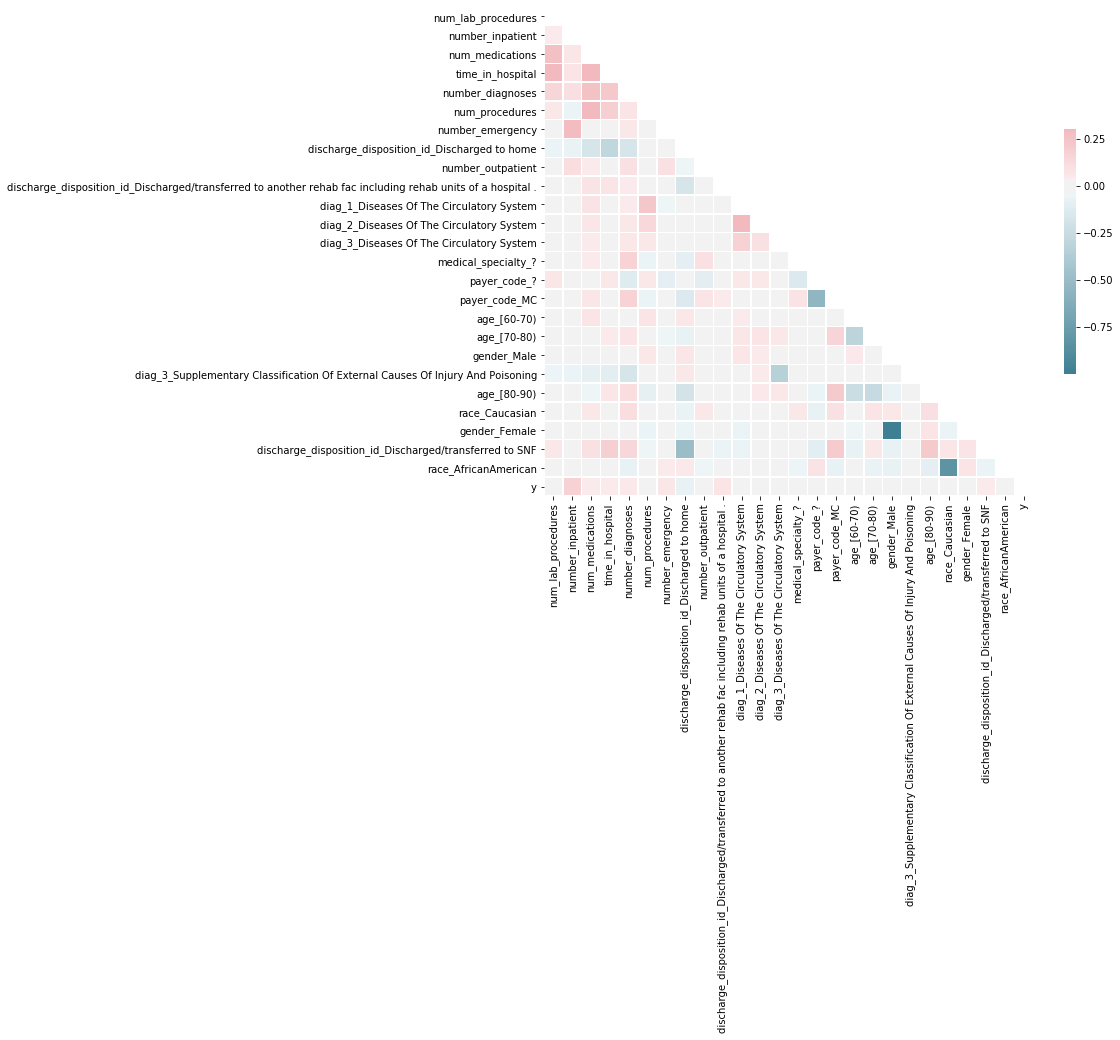

In [58]:
# sns.pairplot(sub_x)

# Compute the correlation matrix
corr = sub_x.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [59]:
sub_x = sub_x.drop(['y'], axis=1)

In [60]:
sub_x.shape

(75085, 25)

## My top 25 features keep the recall at .60, .61 - slightly higher with re-tweaking hyperparameters

In [63]:
randomforest = RandomForestClassifier(n_estimators=300, min_samples_split=70)
randomforest.fit(x_train_undersampled, y_train_undersampled)
y_pred = randomforest.predict(x_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         <30       0.18      0.64      0.28      2839
          NO       0.93      0.63      0.75     22190

    accuracy                           0.63     25029
   macro avg       0.56      0.63      0.51     25029
weighted avg       0.85      0.63      0.70     25029



In [64]:
# pickle model for predictor app
with open('randomforest.pkl', 'wb') as picklefile:
    pickle.dump(randomforest, picklefile)

Text(68.09375, 0.5, 'True')

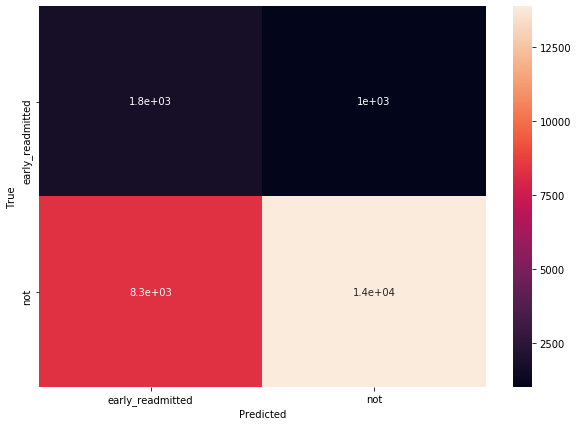

In [65]:
array = metrics.confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(array, index = ['early_readmitted', 'not'],
                  columns = ['early_readmitted', 'not'])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')

In [66]:
from sklearn.metrics import precision_recall_curve

In [67]:
y_test_num = y_test.copy()
y_test_num = y_test_num.replace('NO', 0)
y_test_num = y_test_num.replace('<30', 1)

Text(0.5, 1.0, 'Precision Recall Curve')

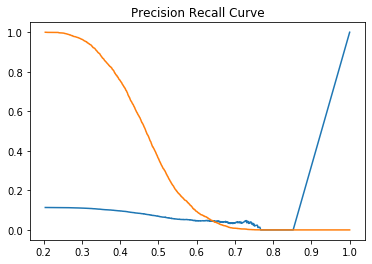

In [68]:
model = randomforest

y_score = model.predict_proba(x_test)[:, 1]
p, r, t = precision_recall_curve(y_test_num, y_score)

# adding last threshold of '1' to threshold list
t = np.vstack([t.reshape([-1, 1]), 1])

plt.plot(t, p)
plt.plot(t, r)
plt.title('Precision Recall Curve')
# yellow = recall
# blue = precision

In [69]:
y_score

array([0.49950422, 0.60856074, 0.65753281, ..., 0.57354681, 0.57481236,
       0.59052453])

## Choosing classification threshold based on the cost benefit analysis function:

In [ ]:
for t in range(0,1,0.1):
    

In [ ]:
# alternatively, i could have thresholds as columns in a dataframe 
# with y_test and y_pred as the first two columns
# and then calculate the false positive and false negative numbers per column

costs = []

for t in np.arange(0,1,0.1):
    y_pred = [int(1) if i > t else int(0) for i in model.predict_proba(x_test)[:, 1]]
    FP = [int(1) if y_pred[i]==1 and y_test_num[i]==0 else int(0) for i in range(len(y_pred)) ]
    TP = [int(1) if y_pred[i]==1 and y_test_num[i]==1 else int(0) for i in range(len(y_pred)) ]
    FN = [int(1) if y_pred[i]==0 and y_test_num[i]==1 else int(0) for i in range(len(y_pred)) ]
    TN = [int(1) if y_pred[i]==0 and y_test_num[i]==0 else int(0) for i in range(len(y_pred)) ]

    FPsum = FP.sum()
    TPsum = TP.sum()
    FNsum = FN.sum()
    TNsum = TN.sum()   
    
    cost = FPsum*304 + TPsum*(304-1246) + FNsum*1246

    costs.append(cost)

print(costs)
    
    # for each threshold, calculate values from the FP + FN

    # for each true positive, we have 304-1246
    # for each false positive, we lose 304 per day
    # for each false negative, we lose 1246 per day
    # for each true negative, we lose 0 per day

# median cost first day 1,246

# variable costs per day of hospital stay:
# https://www.journalacs.org/article/S1072-7515(00)00352-5/fulltext
    
# $2,289 nonprofit hospital average
# https://www.beckershospitalreview.com/finance/average-cost-per-inpatient-day-across-50-states.html


In [ ]:
y_proba = model.predict_proba(x_test)
prec_log = {}
rec_log = {}
acc_log = {}
cost_ben_log = {}

for readmit_cost in range(300, 3300, 300):
    for i in np.arange(0,1,.01):
        i = np.round(i,2)
        y_pred_high_precision = y_proba[:,1] >= i 
        y_pred_high_precision
        conf = metrics.confusion_matrix(y_test_num,y_pred_high_precision)

        ac_log = round(metrics.accuracy_score(y_test_num,y_pred_high_precision),4)
        pc_log = (conf[1, 1] / (conf[1, 1] + conf[0, 1]))
        rc_log = (conf[1, 1] / (conf[1, 1] + conf[1, 0]))

        acc_log[i]= ac_log
        prec_log[i]= pc_log
        rec_log[i] = rc_log

        FPsum = conf[0, 1]
        TPsum = conf[0, 0]
        FNsum = conf[1, 0]
        TNsum = conf[1, 1]

        #cost_ben_log[i] = FPsum*304 + TPsum*(304-1246) + FNsum*1246
        #day_cost = 304
        #readmit_cost = 1246
        day_cost = 300
        #readmit_cost = 2500
        cost_ben_log[i] = (FPsum*day_cost + TPsum*(day_cost-readmit_cost) + FNsum*(readmit_cost))/len(y_test_num)
        # FP = stay in hospital, but didn't need to, costs $304/day
        # TP = stay in hospital and needed to, costs $304/day but saves $1246
        # FN = readmitted, but should have stayed in hospital, saved $304, but costed $1246
        # TN = left hospital, not readmitted, no cost

        # metrics.
        # TN  # FP
        # FN  # TP

        #print(min(cost_ben_log.values()))

    zipped = zip(cost_ben_log.keys(), cost_ben_log.values())
    print(sorted(zipped, key=lambda x: x[0]))

    plt.plot(cost_ben_log.keys(),cost_ben_log.values(),label=readmit_cost)
    plt.legend();
    plt.xlabel("Threshold")
    plt.ylabel("Cost ($)")
    plt.grid()
    plt.title('Cost per Intervention - Random Forest')
    plt.savefig("Cost_PerIntervention_Random_Forest");

In [ ]:
y_proba = model.predict_proba(x_test)
prec_log = {}
rec_log = {}
acc_log = {}
cost_ben_log = {}

for i in np.arange(0,1,.01):
    i = np.round(i,2)
    y_pred_high_precision = y_proba[:,1] >= i 
    y_pred_high_precision
    conf = metrics.confusion_matrix(y_test_num,y_pred_high_precision)
    
    ac_log = round(metrics.accuracy_score(y_test_num,y_pred_high_precision),4)
    pc_log = (conf[1, 1] / (conf[1, 1] + conf[0, 1]))
    rc_log = (conf[1, 1] / (conf[1, 1] + conf[1, 0]))
    
    acc_log[i]= ac_log
    prec_log[i]= pc_log
    rec_log[i] = rc_log
        
    FPsum = conf[0, 1]
    TPsum = conf[0, 0]
    FNsum = conf[1, 0]
    TNsum = conf[1, 1]
    
    #cost_ben_log[i] = FPsum*304 + TPsum*(304-1246) + FNsum*1246
    #day_cost = 304
    #readmit_cost = 1246
    day_cost = 304
    readmit_cost = 1246
    cost_ben_log[i] = (FPsum*day_cost + TPsum*(day_cost-readmit_cost) + FNsum*(readmit_cost))/len(y_test_num)
    # FP = stay in hospital, but didn't need to, costs $304/day
    # TP = stay in hospital and needed to, costs $304/day but saves $1246
    # FN = readmitted, but should have stayed in hospital, saved $304, but costed $1246
    # TN = left hospital, not readmitted, no cost
            
print(conf)
plt.plot(acc_log.keys(),acc_log.values(),label="Accuracy")
plt.plot(rec_log.keys(),rec_log.values(),label="Recall")
plt.plot(prec_log.keys(),prec_log.values(),label="Precision")
# plt.plot(cost_ben.keys(),cost_ben.values(),label="Cost Benefit")
plt.legend()
plt.grid()
plt.xlabel("Threshold")
plt.ylabel("Precision / Recall / Accuracy")
plt.title('Precision / Recall / Accuracy curve');
plt.axvline(x=0.49, linestyle = '--', linewidth=0.5, color='r')
plt.axhline(y=0.42, linestyle = '--', linewidth=0.5, color='r')

# metrics.
# TN  # FP
# FN  # TP

In [ ]:
#print(min(cost_ben_log.values()))

zipped = zip(cost_ben_log.keys(), cost_ben_log.values())
print(sorted(zipped, key=lambda x: x[0]))

plt.plot(cost_ben_log.keys(),cost_ben_log.values(),label="Cost")
plt.legend();
plt.xlabel("Threshold")
plt.ylabel("Cost ($)")
plt.grid()
plt.title('Cost per Intervention - Random Forest')
plt.savefig("Cost_PerIntervention_Random_Forest");

In [ ]:
for i in np.arange(0.01,1.01,0.05):
    y_pred_high_precision = y_proba[:,1] >= i 
    y_pred_high_precision
    conf = metrics.confusion_matrix(y_test,y_pred_high_precision)
    print(f"Threshold at {round(i,2)} \n")
    print(conf)
    print("")
    test_thresh = np.round(i,2)
    print(f"Threshold: {test_thresh}")
    print(f"Accuracy: {acc_log[test_thresh]}")
    print(f"Precision: {prec_log[test_thresh]}")
    print(f"Recall: {rec_log[test_thresh]}")
    print(f"Cost-Benefit: {cost_ben_log[test_thresh]}" )
    print("********************************")
    
#         cost_ben_log[i] = ((250 * (1-rc_log)) + (100*(1-pc_log)) - (150*pc_log))*100



Add CommentCollapse 

In [ ]:
from pandas_ml import ConfusionMatrix

confusion_matrix = ConfusionMatrix(y_test, y_pred)
confusion_matrix.plot()

In [ ]:
labels = ['early_readmitted', 'not']
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## RandomSearchCV for Random Forest Hyperparameter Tuning:

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}
print(random_grid)

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()

# Random search of parameters

# using x-num fold cross validation
cv_num = 3

# search across x-num different combinations
n_iter_num = 20

# and use all available cores

rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                               n_iter=n_iter_num, cv=cv_num, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
rf_random.fit(x_train_undersampled, y_train_undersampled)

In [ ]:
rf_random.best_estimator_

In [ ]:
randomforest = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=70, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=100,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [ ]:
randomforest.fit(x_train_undersampled, y_train_undersampled)
randomforest.score(x_test, y_test)
y_pred = randomforest.predict(x_test)
print("Accuracy: %.3f"% metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

## RandomsearchCV:

In [71]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()

# Random search of parameters

# using x-num fold cross validation
cv_num = 3

# search across 100 different combinations
n_iter_num = 20

# and use all available cores

rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                               n_iter=n_iter_num, cv=cv_num, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/usr/local/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  8.6min


In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [ ]:
# How does the baseline/benchmark model perform?
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(train_features, train_labels)
base_accuracy = evaluate(base_model, test_features, test_labels)

In [ ]:
# How does the new model perform?
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, test_features, test_labels)

In [ ]:
# How much did we improve? 
# Accuracy is a poor metric to be using here, since the dataset has imbalanced classes and 
# we should probably care more about recall of the early readmission class.

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [ ]:
randomforest = RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=70, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=1200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

randomforest.fit(x_train, y_train)
y_pred = randomforest.predict(x_test)
print(metrics.classification_report(y_test, y_pred))

In [ ]:
randomforest = RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=70, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=1200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

randomforest.fit(x_train, y_train)
y_pred = randomforest.predict(x_test)
print(metrics.classification_report(y_test, y_pred))